# Introduction

*   For this project, we will be working to understand the results of an A/B test run by an e-commerce website.
* The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product.
* Our goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.



## Formulating a hypothesis
Firstly, we need to formulate a hypothesis at the start of our project. This will make sure our interpreattion of the result is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a two tailed test.

**Business Hypothesis**
- $H_0$ : The new page's conversion rate is the same as the old page
- $H_1$ : The new page's conversion rate is different than the old page

**Statistical Hypothesis**

- $H_0 : p = p_0$

- $H_1 : p \not= p_0$

We set the confidence level as 95% which will give us α = 0.05 and we are happy to see the difference of 2% conversion rate.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

The data used in this project is [E-commerce A/B Testing](https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing) data from the Kaggle platform.

Because I already downloaded the dataset, I will continue to read the data into a pandas DataFrame.

In [30]:
df = pd.read_csv('/content/ab_test.csv')
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


# Part I - Exploratory Data Analysis

In [31]:
# change cplumn names to a more easy-to-understood name
df.columns = ['user_id', 'timestamp', 'group', 'landing_page', 'converted']
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [32]:
# number of rows and unique users
print(f'Number of ros: {df.shape[0]}')
print(f'Number of unique users: {df.user_id.nunique()}')

Number of ros: 294478
Number of unique users: 290584


In [33]:
# get general info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [34]:
# check missing value
df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [35]:
# check duplicated rows
df.duplicated().sum()

np.int64(0)

In [36]:
# check duplicated rows by user_id
df.duplicated(subset='user_id').sum()

np.int64(3894)

In [37]:
# get duplicated data by user_id
df[df.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2656,698120,13:42.6,control,old_page,0
2893,773192,55:59.6,treatment,new_page,0
7500,899953,06:54.1,control,new_page,0
8036,790934,32:20.3,treatment,new_page,0
10218,633793,16:00.7,treatment,old_page,0
...,...,...,...,...,...
294308,905197,56:47.5,treatment,new_page,0
294309,787083,15:21.0,control,old_page,0
294328,641570,59:27.7,control,old_page,0
294331,689637,34:28.3,control,new_page,0


In [38]:
# explore several users
df[df['user_id']==	899953]

,user_id,timestamp,group,landing_page,converted
3489,899953,36:02.1,treatment,new_page,0
7500,899953,06:54.1,control,new_page,0


- Using groupby, check if there are any mismatch

- control should go to old_page only, treatment shoudl go to new_page only

In [39]:
df.groupby(['group', 'landing_page']).size()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

In [40]:
(1928 + 1965) / len(df)

0.013220002852505111

- The mismatched rows is only 1.32% of the whole data.

- Deleting these mismatched rows does not seems like it will affect the overall conclusion of our data.

# Part II - Data Cleaning

In [52]:
# get clean data only
df_clean = df[(df['group']=='treatment') & (df['landing_page']=='new_page') | (df['group']=='control') & (df['landing_page']=='old_page')]

len(df_clean)

290585

In [53]:
# get duplicates data
df_clean[df_clean.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [54]:
df_clean[df_clean['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


- It seems like the duplicated user ID can be rationalized as same user which lands on new page two times but decided not to convert both times

- In this case, we can simply delete one of the entry and treat the user as non-converted user

In [55]:
df_clean = df_clean.drop_duplicates('user_id', keep='first')

df_clean[df_clean.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted


- Now that our DataFrame is nice and clean.

# Part III - Data Visualization

The first thing we can do is to calculate some basic statistics to get an idea of what our samples look like.

In [41]:
df.groupby('landing_page')['converted'].agg(['mean', 'std'])

,mean,std
landing_page,,
new_page,0.118841,0.323602
old_page,0.120478,0.325520


- Judging by the stats above, It seems like the new page performs worse than the old page
- It also seems like, while the new page performs worse, the change of conversion rate does not suggest that there is much change when we use the new page (12% vs 11.9%)
- Plotting the data will make these results easier to grasp

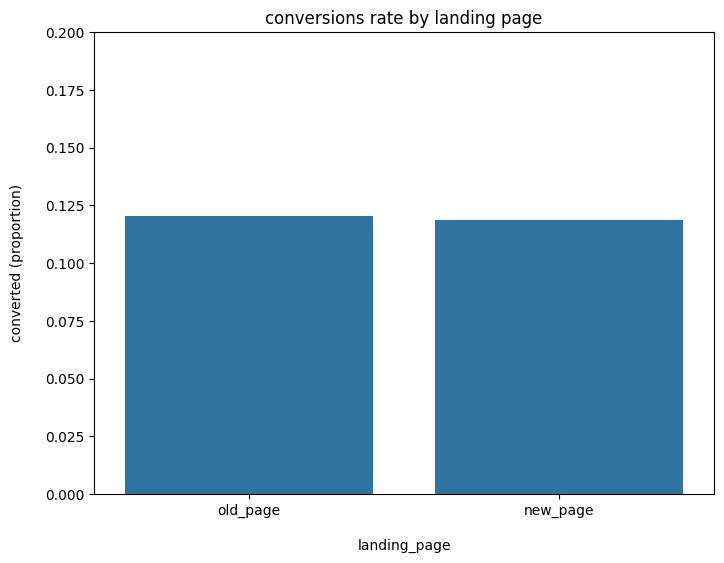

In [57]:
plt.figure(figsize=(8,6))

sns.barplot(x=df_clean['landing_page'], y=df_clean['converted'], errorbar=('ci', False))

plt.ylim(0, 0.2)
plt.title('conversions rate by landing page')
plt.xlabel('landing_page', labelpad=15)
plt.ylabel('converted (proportion)', labelpad=15)

plt.savefig('temp.png', dpi=300)

plt.show()

# Part IV - Hypothesis Testing

## Checking if we have enough sample

- We need to check if we, in fact, have enough sample to make any conclusion about the difference in conversion rate.

- To do this, we need to determine the number of sampe needed. Remember that the number of sample needed is determined by several factors:

  - Power (1 - β) : Probability of finding a statistical difference between groups in our test when difference is actually present.
  - Critical value (α)
  - Effect size: how big of a difference of conversion rate we expect there to be.


- As before, we would be happy to see the difference of 2% conversion rate.

In [60]:
# checking the conversion rate of the control group
control_convertrate = df_clean[df_clean['group'] == 'control']['converted'].mean()
control_convertrate

np.float64(0.1203863045004612)

- Conversion rate of control group : 12.039%

- Based on this, we can use 12.039% and 14.029% to calculate the effect size we expect.

In [58]:
import scipy.stats as stats
import statsmodels.stats.api as sms

In [61]:
effect_size = sms.proportion_effectsize(control_convertrate, control_convertrate+0.02)

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )


print("required data for each group : " + str(required_n))

required data for each group : 4443.697348252334


- For this experiment, we need at least 4444 observations for each group.

- Let's find out how many data we have for each group!

In [62]:
df_clean['group'].value_counts()

,count
group,
treatment,145310
control,145274


- We have around 145000 data for each group.

- This data size is way larger than the required 4444 data for each group.

- We can safely say that our data size is already large enough for us to conduct this experiment to find whether the new page can increase the conversion rate by 2%.

## Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our  
*p*-value (i.e. z-test).

In [64]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [66]:
control_results = df_clean[df_clean['group'] == 'control']['converted']
treatment_results = df_clean[df_clean['group'] == 'treatment']['converted']

In [67]:
n_con = control_results.count()
n_treat = treatment_results.count()

In [68]:
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [71]:
z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative='two-sided')

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.31
p-value: 0.190
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.120]


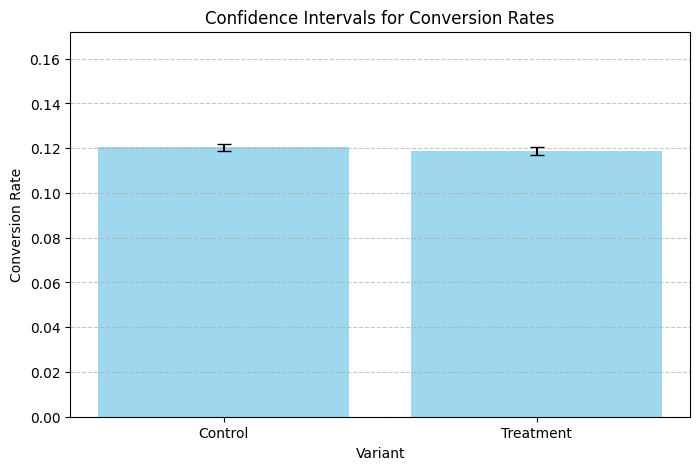

In [72]:
variants = ['Control', 'Treatment']
means = [control_results.sum() / n_con, treatment_results.sum() / n_treat]  # Conversion rates
ci_lower = [lower_con, lower_treat]
ci_upper = [upper_con, upper_treat]

# Calculate the error bars (difference between the means and the confidence bounds)
error_lower = [mean - lower for mean, lower in zip(means, ci_lower)]
error_upper = [upper - mean for upper, mean in zip(ci_upper, means)]

# Plot the confidence intervals
plt.figure(figsize=(8, 5))
plt.bar(variants, means, color='skyblue', yerr=[error_lower, error_upper], capsize=5, alpha=0.8)
plt.title('Confidence Intervals for Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Variant')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(ci_upper) + 0.05)  # Add some space above the largest upper bound

# Save the plot
plt.savefig('CI Comparison for Conversion Rates',dpi=300)

# Display the plot
plt.show()

# Part V - Conclusion

- The p-value from the test result  is 0.19 which is above our threshold of α = 0.05.


- The statistical conclusion would be that we failed to reject the null hypothesis.

- We don't have enough statistical evidence to conclude that the new page resulted in better / worse conversion rate for our platform.

- With this result, we can safely say that we should not implement the new design at the moment.
